In [8]:
from tensorly.decomposition import non_negative_parafac,parafac,non_negative_tucker,partial_tucker,tucker
from tensorly.regression import KruskalRegressor
import tensorly as tl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [70]:
'''
x needs to be a dataframe which says 
for each patient, neighborhood and cell type, how many cells of that type in that neighborhood there are

cells of interest are the cells to be used in the decomposition
CNs is the CNs to be used in the decomposition
patients are the patients to be used in the decomposition
'''

x = pd.read_csv('main_fcs_csv.csv')
neigh_col = 'neighborhood10'
cells_of_interest = ['B Cells', 'CD4 T cells','CD8 T cells', 'TRegs']
nbs = [0,2,3,4,5,6,7,8,9]
patients = [1,2,3,4,5,6,7]

In [44]:
def build_tensor(patients,x,nbs,cells_of_interest):
    T = np.zeros((len(patients),len(nbs),len(cells_of_interest)))
    for i,nb in enumerate(nbs):
        for j,chk in enumerate(cells_of_interest):
            T[:,i,j] = x.loc[x['neighborhood10']==nb,:].set_index('patients').loc[patients,chk].fillna(0).values
        
        
    #normalize each patient's frequencies
    dat =np.nan_to_num(T/T.sum((1,2), keepdims = True))
    return dat


In [45]:
def decomposition_elbow(dat):
    pal = sns.color_palette('bright',10)
    palg = sns.color_palette('Greys',10)
    mat1 = np.zeros((5,15))
    #finding the elbow point
    for i in range(2,15):
        for j in range(1,5):
            facs_overall = non_negative_tucker(dat,rank=[j,i,i],random_state = 2336)
            mat1[j,i] = np.mean((dat- tl.tucker_to_tensor(tucker_tensor = (facs_overall[0],facs_overall[1])))**2)

    figsize(10,5)
    plt.plot(2+np.arange(13),mat1[2][2:],c = 'red',label = 'rank = (2,x,x)')
    plt.plot(2+np.arange(13),mat1[1][2:],c = 'blue',label = 'rank = (1,x,x)')
    plt.xlabel('x')
    plt.ylabel('error')
    plt.show()
    

In [94]:
def tissue_module_plots(dat, person_rank,rank,nbs,cells_of_interest,random_state = 0):
    facs_overall = non_negative_tucker(dat,rank=[person_rank,rank,rank],random_state = random_state)
    print(facs_overall[0].shape)
    sns.heatmap(pd.DataFrame(facs_overall[1][1], index = nbs))
    plt.ylabel('CN')
    plt.xlabel('CN module')
    plt.title('CN modules')
    plt.show()
    
    sns.heatmap(pd.DataFrame(facs_overall[1][2], index = cells_of_interest))
    plt.ylabel('CT')
    plt.xlabel('CT module')
    plt.title('CT modules')
    plt.show()
    
    print('--------Tissue modules ---------')
    for i in range(person_rank):
        
        sns.heatmap(pd.DataFrame(facs_overall[0][i]))
        plt.ylabel('CN module')
        plt.xlabel('CT module')
        plt.title('Tissue module {}'.format(i))
        plt.show()
        
    
    
    return facs_overall

In [95]:
#use random data for sake of demonstration
np.random.seed(123)
dat = 10+np.random.normal([1]*140).reshape(len(patients),len(nbs),len(cells_of_interest))


#dat = build_tensor(patients,x,nbs,cells_of_interest)

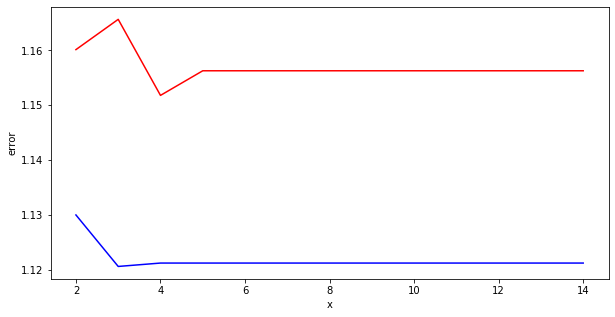

In [96]:
#compute elbow point for decomposition
decomposition_elbow(dat)

(2, 3, 3)


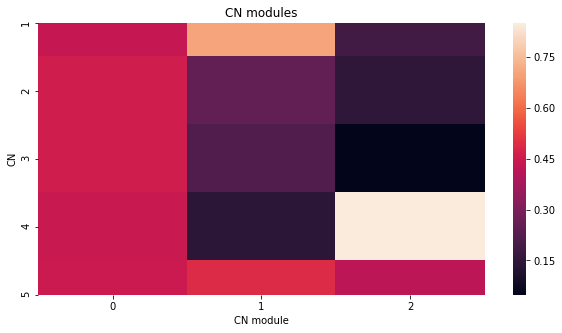

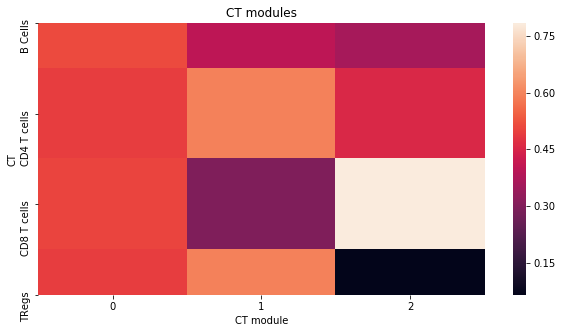

--------Tissue modules ---------


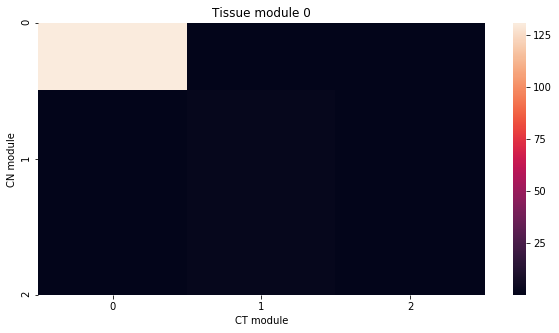

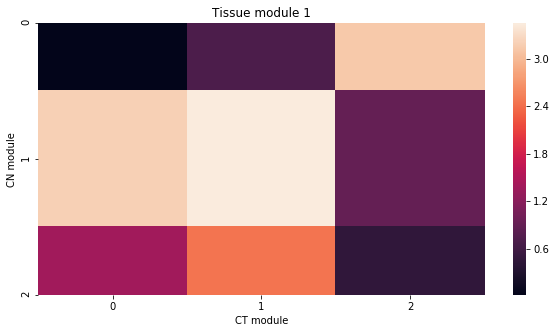

In [97]:
#compute CN modules, CT modules and couplings
facs_overall = tissue_module_plots(dat,2,3,nbs,cells_of_interest)